# Flow analysis

## Importing libraries

In [1]:
import copy

import cv2
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import os

# Method: optical flow

## Opening experimental data information

In [2]:
folder_name = './data/180425'
forces_filename = os.path.join(folder_name, 'flow.csv')

in_folder = './data/180425/flow/front'
out_folder = './out/180425/flow/front'
video_extension = 'MOV'

df = pd.read_csv(
    forces_filename,
    delimiter=";",
    decimal=",",
    dtype={ # Set as a category all controlled parameters of the experiment
        'wing_name': 'category',
    }
)

## Generating motion heatmaps

In [ ]:
num_images = 50

if not os.path.exists(out_folder):
    os.makedirs(out_folder)

for _, experiment in df.iterrows():
    n = experiment['n']
    print(f'Treating experiment {n}')

    cap = cv2.VideoCapture(
        os.path.join(in_folder, f'{n}.{video_extension}')
    )

    ret, first_frame = cap.read()
    assert ret

    previous_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    (width, height) = previous_gray.shape

    motion_magnitude = np.zeros_like(first_frame[:, :, 0], dtype=np.float32)

    for i in range(num_images):
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculer le flux optique entre les images successives
        flow = cv2.calcOpticalFlowFarneback(previous_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # Calculer la magnitude du mouvement
        magnitude, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        motion_magnitude += magnitude

        previous_gray = gray

    # Normaliser la magnitude pour l'affichage
    motion_magnitude_normalized = cv2.normalize(motion_magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    color_motion = cv2.applyColorMap(motion_magnitude_normalized, cv2.COLORMAP_HOT)
    motion_overlay = cv2.addWeighted(first_frame, 0.7, color_motion, 0.7, 0)

    # save the final heatmap
    np.save(os.path.join(out_folder, f'{n}.npy'), motion_magnitude_normalized)
    cv2.imwrite(os.path.join(out_folder, f'{n}_frame.jpg'), first_frame)
    cv2.imwrite(os.path.join(out_folder, f'{n}_motion.jpg'), color_motion)
    cv2.imwrite(os.path.join(out_folder, f'{n}_overlay.jpg'), motion_overlay)

    cap.release()

## Width and height averaging

In [3]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = make_subplots(rows=25, cols=1, shared_xaxes=True, shared_yaxes=True, subplot_titles=np.linspace(-24, 24, 25), vertical_spacing=0.001)

x_min = 0
x_max = 870
y_min = 84
y_max = 1150

colorscale = px.colors.sequential.Viridis  # a list of hex colours
α_min, α_max = -24, 24

def α_to_color(α):
    # normalize α into [0,1]
    t = (α - α_min) / (α_max - α_min)
    # pick the corresponding colour index
    idx = int(t * (len(colorscale) - 1))
    return colorscale[idx]

study_df = df[(df['wing_name'] == 'NACA4412') & (df['U'] == 29.2)]

mean_df = pd.DataFrame(columns=['attack', 'x', 'motion'])

for file in os.listdir(out_folder):
    if file.endswith(".npy"):
        n = file.strip('.npy')
        info_row = study_df[study_df['n'] == int(n)]
        if len(info_row) == 0:
            continue

        info_row = info_row.iloc[0]
        attack = info_row['attack']
        motion = np.load(os.path.join(out_folder, file))
        cropped_motion = motion[x_min:x_max, y_min:y_max]
        whole_motion = cropped_motion.sum(axis=1)

        motion_df = pd.DataFrame({
            'x': np.linspace(x_min, x_max, x_max-x_min),
            'motion': whole_motion
        })
        motion_df['attack'] = attack

        mean_df = pd.concat((
            mean_df,
            motion_df
        ))

C:\Users\theov\AppData\Local\Temp\ipykernel_4156\2500612432.py:45: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



## Results plotting

<Figure size 2100x2700 with 0 Axes>

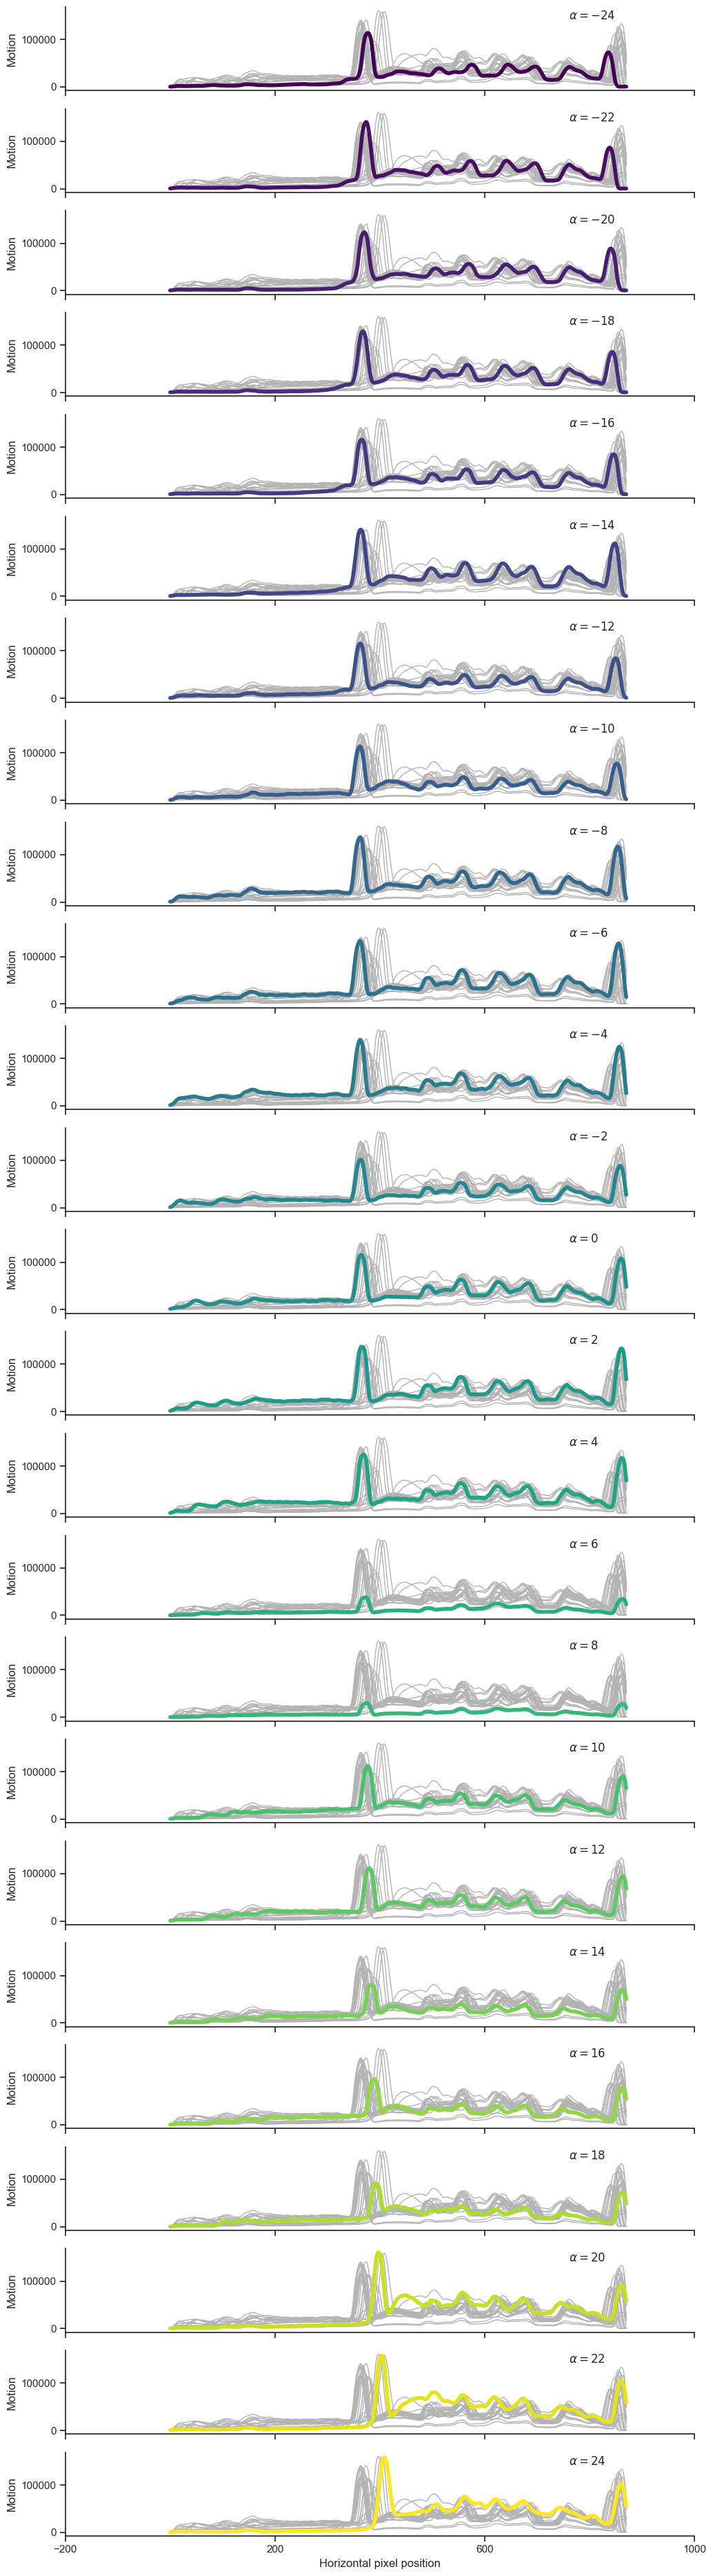

In [5]:
import seaborn as sns

sns.set_theme(style="ticks")

plt.figure(figsize=(21, 3*9))
g = sns.relplot(
    data=mean_df,
    x='x', y='motion', row='attack', hue='attack',
    kind='line', palette='viridis', linewidth=4, zorder=5,
    height=1.5, aspect=7, legend=False,
)

# Iterate over each subplot to customize further
for attack, ax in g.axes_dict.items():
    ax.text(.8, .85, f'$\\alpha = {attack}$', transform=ax.transAxes, fontweight="bold")

    sns.lineplot(
        data=mean_df, x="x", y="motion", units="attack",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("Horizontal pixel position", "Motion")
g.tight_layout()

In [ ]:

fig.add_trace(
    go.Scatter(
        x=np.linspace(x_min, x_max, x_max-x_min+1),
        y=cropped_motion.mean(axis=1),
        name=f"alpha = {attack}",
        mode='lines',
        line=dict(color=α_to_color(attack), width=3)
    ),
    row=int(attack/2 + 13),
    col=1
)

fig.update_yaxes(matches="y")
fig.update_layout(height=100*25)
fig.show()

Positions are overall the same, but amplitudes vary much -> more movement at high attack angles

In [ ]:
# Averaging on the height of the airfoil
plt.plot(np.linspace(0, height, height), selected_motion.mean(axis=0))

# Method: feature tracking

In [ ]:
video_path = "data/180425/flow/front/61.MOV"
cap = cv2.VideoCapture(video_path)

tracker = cv2.TrackerCSRT.create()

initBB = None

# Inspired by https://pyimagesearch.com/2018/07/30/opencv-object-tracking/
while True:
    ret, frame = cap.read()
    if not ret:
        break
    (H, W) = frame.shape[:2]

    imgray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 100, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if initBB is not None:
        # grab the new bounding box coordinates of the object
        (success, box) = tracker.update(frame)
        # check to see if the tracking was a success
        if success:
            (x, y, w, h) = [int(v) for v in box]
            cv2.rectangle(frame, (x, y), (x + w, y + h),
                          (0, 255, 0), 2)

    cv2.drawContours(frame, contours, -1, (0,255,0), 3)
    cv2.imshow('Frame', frame)

    if initBB is None:
        initBB = cv2.selectROI("Frame", frame, fromCenter=False,
                               showCrosshair=True)
        tracker.init(frame, initBB)

    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break

cv2.destroyAllWindows()
cap.release()

In [ ]:
cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np

video_path = "data/180425/flow/front/61.MOV"
cap = cv2.VideoCapture(video_path)

cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)

ret, frame = cap.read()
if not ret:
    print("Failed to capture frame")
    exit()

prev_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

all_selected = True
selected_point = None

# Step 2: Define the mouse callback function to capture the click position
def select_point(event, x, y, flags, param):
    global selected_point
    if event == cv2.EVENT_LBUTTONDOWN:
        selected_point = (x, y)
        print(f'Selected point: {selected_point}')

cv2.setMouseCallback('Frame', select_point)

while selected_point is None:
    cv2.imshow('Frame', frame)

    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        exit()

initial_points = np.array([[[selected_point[0], selected_point[1]]]], dtype=np.float32)

# Create an empty mask to draw the points and trajectory
mask = np.zeros_like(frame)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow (track points)
    next_points, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, gray, initial_points, None)
    if next_points is not None:
        # Select good points
        good_new = next_points[status == 1]
        good_old = initial_points[status == 1]

        #  Draw the trajectory (if you are tracking the tip of the tuft)
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
            frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

        prev_gray = gray.copy()
        initial_points = good_new.reshape(-1, 1, 2)

    output = cv2.add(frame, mask)

    cv2.imshow('Frame', output)

    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break

# Step 15: Release resources
cap.release()
cv2.destroyAllWindows()

In [ ]:
cv2.destroyAllWindows()

# Method: comparison with gaussian background

Source: [Labellerr](https://www.labellerr.com/blog/ml-guide-to-create-a-heat-mapping-model/)

In [ ]:
video_path = "data/180425/flow/front/61.MOV"
cap = cv2.VideoCapture(video_path)
threshold = 128
debug = False

background_subtractor = cv2.createBackgroundSubtractorMOG2(history=30)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

accum_image = None

for i in range(350):
    # Read the next frame from the video
    ret, frame = cap.read()
    if not ret:
        break

    # The first frame should be treated separately
    if accum_image is None:
        # Store the first frame, its dimensions, and initialize the accumulation image
        first_frame = copy.deepcopy(frame)
        height, width = frame.shape[:2]
        accum_image = np.zeros((height, width), np.uint8)
    else:
        filter = background_subtractor.apply(frame)

        # Threshold the background-subtracted frame
        ret, th1 = cv2.threshold(filter, thresh=threshold, maxval=1, type=cv2.THRESH_TOZERO)

        # contours, _ = cv2.findContours(filter, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # for cnt in contours:
        #     cv2.drawContours(frame, [cnt], -1, (0, 255, 0), 2)

        if debug:
            cv2.imshow("Frame", frame)
            cv2.imshow("Mask", th1)

        key = cv2.waitKey(30)
        if key == 27:
            break

        # Add the thresholded frame to the accumulated image
        # accum_image = cv2.add(accum_image, th1)
        accum_image += th1

cv2.destroyAllWindows()

In [ ]:
scaled_image = cv2.normalize(accum_image, None, 0, 255, cv2.NORM_MINMAX)
color_image = cv2.applyColorMap(scaled_image, cv2.COLORMAP_HOT)
result_overlay = cv2.addWeighted(first_frame, 0.7, color_image, 0.7, 0)

# save the final heatmap
cv2.imwrite('color-motion-background.jpg', color_image)
cv2.imwrite('motion-overlay-background.jpg', result_overlay)
plt.imshow(color_image)

# cleanup
cap.release()